2000 2000 lengths
min pnl: 1.0
average pnl: 1.0184757599051133; average pnl without leverage: 1.0009237879952557
average time spent: 0.75
liquidations / stop losses: 0 
last pnlTotal: [1.07519549 1.        ]


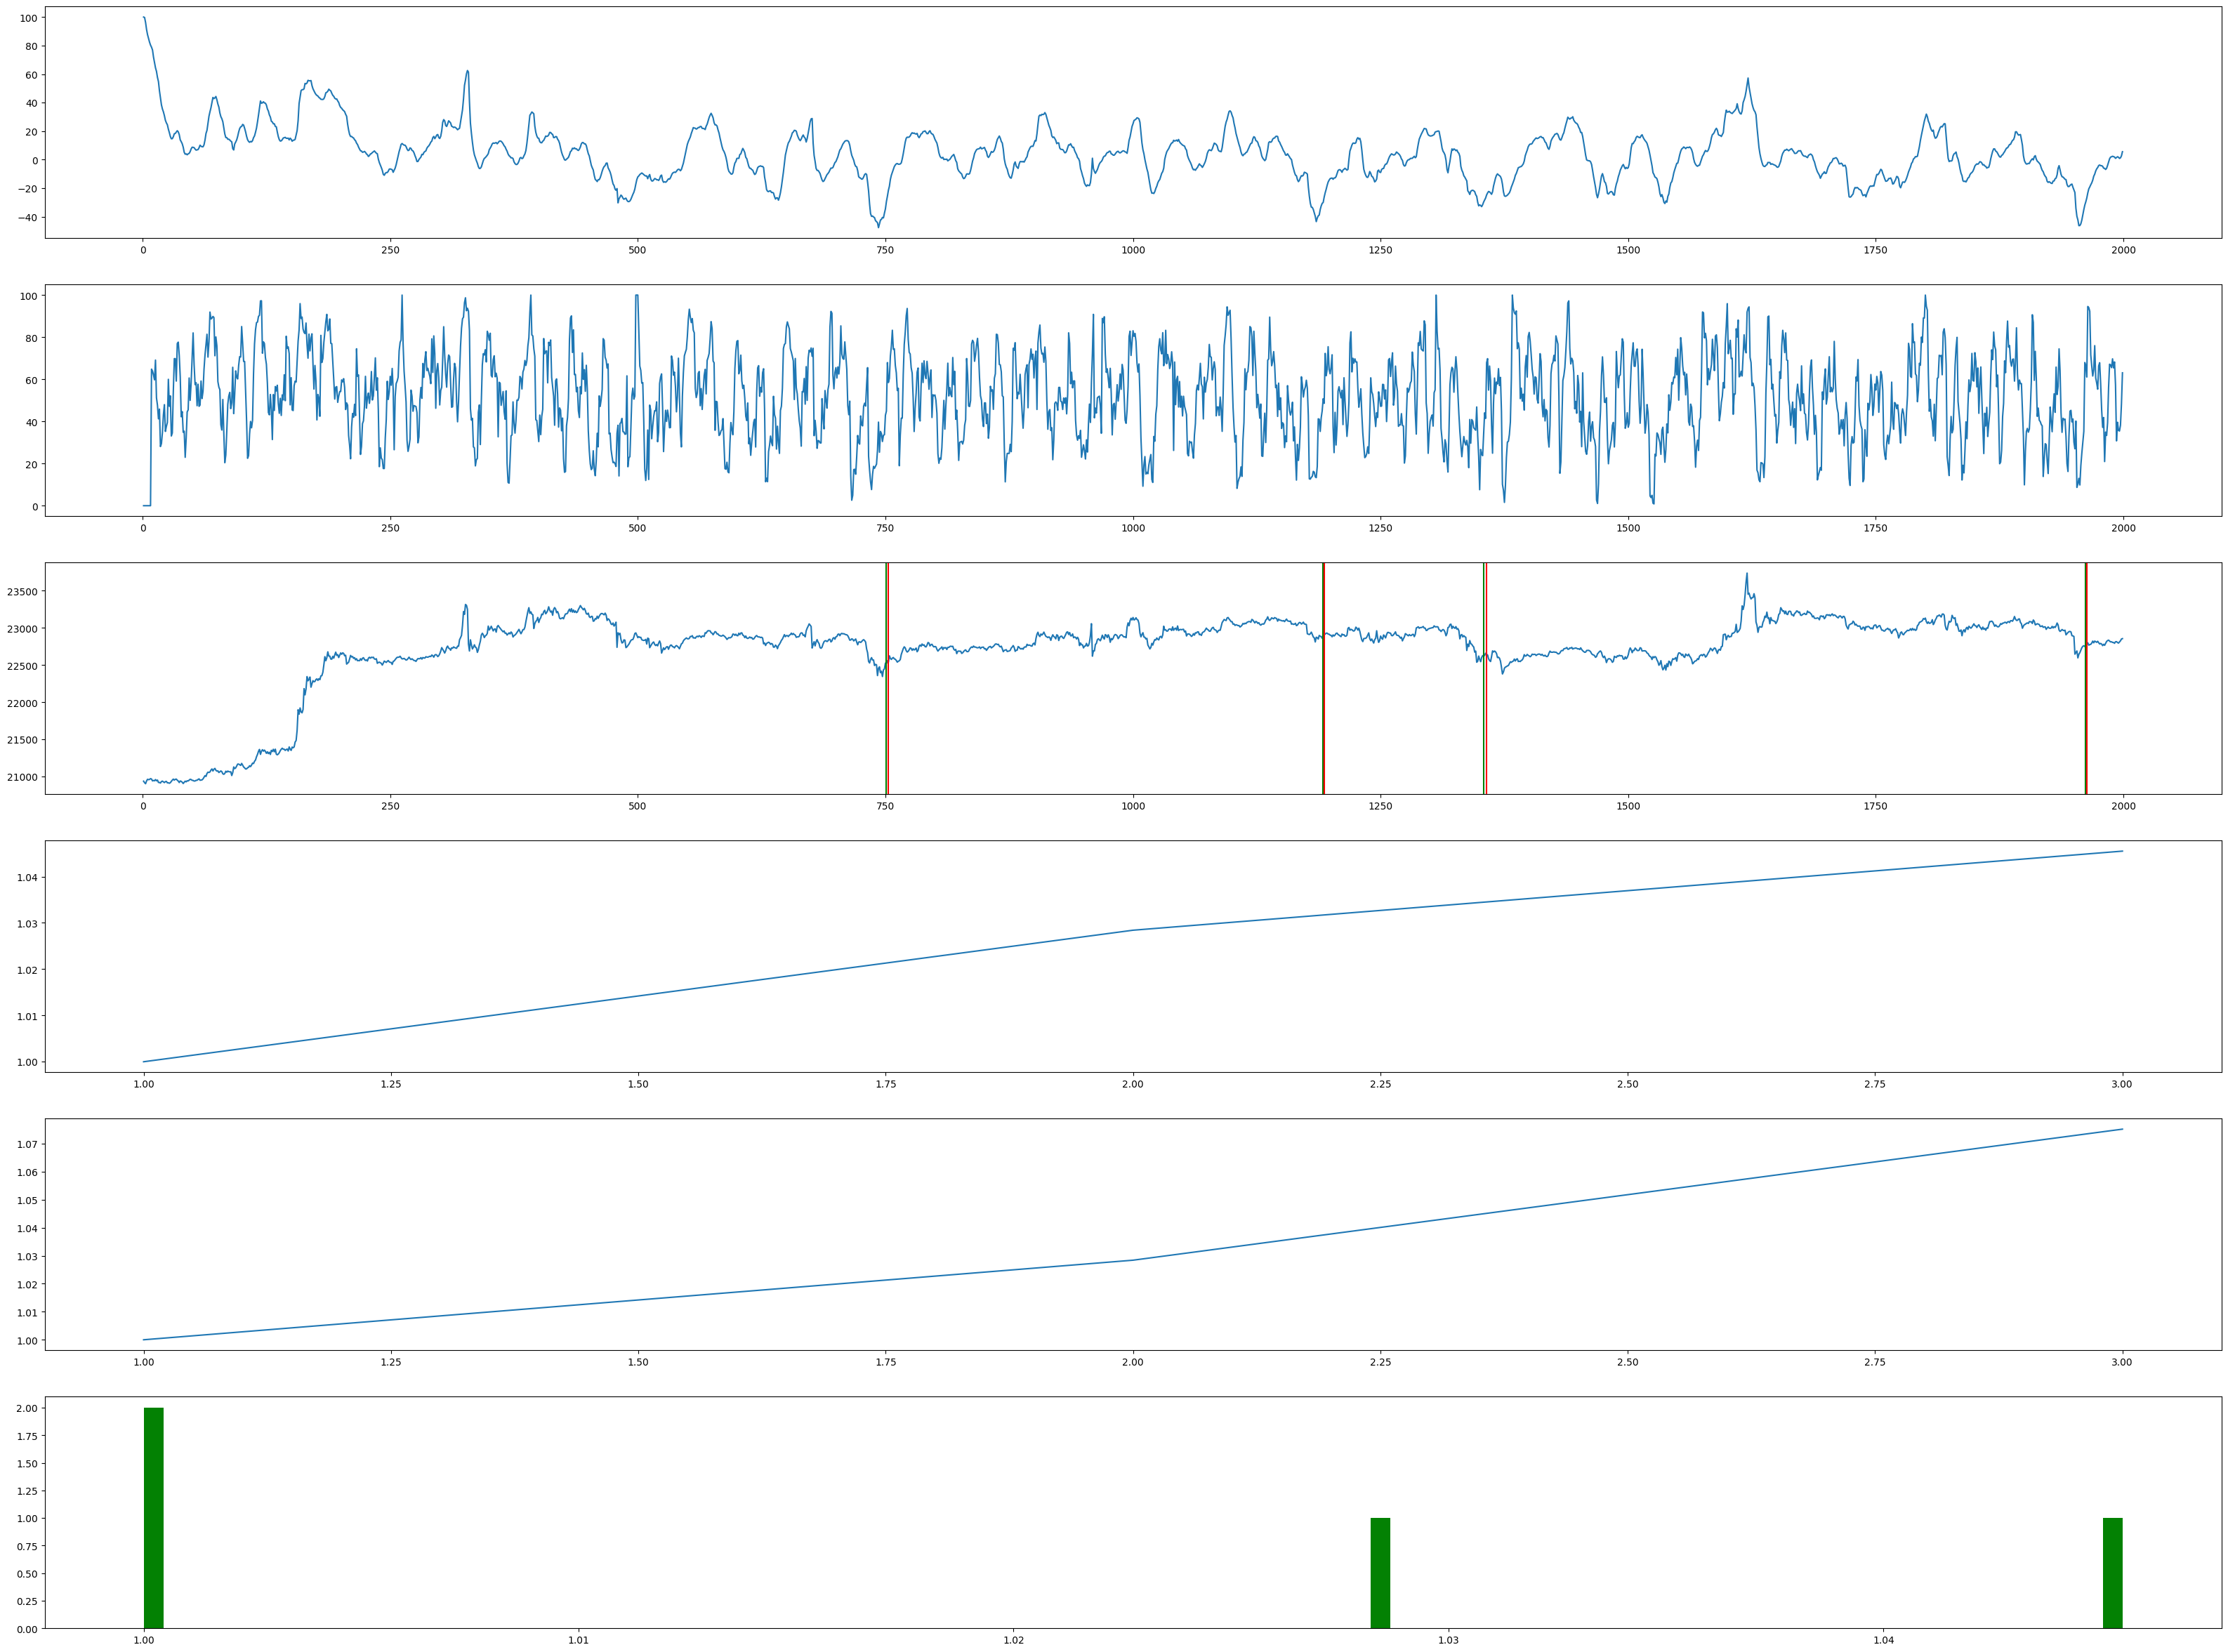

,long/short,entry,exit,index_1,index_2,time,indicatorStart,indicatorEnd,pnl,cumulativePnl,SL
0,1.0,22527.5,22559.5,751.0,753.0,2.0,-29.369073,-21.475151,1.028410,1.028410,-1.0
1,1.0,22860.5,22912.5,1192.0,1193.0,1.0,-29.959872,-26.198005,1.045493,1.075195,-1.0
2,1.0,22627.5,22659.5,1354.0,1357.0,0.0,-29.668669,-24.700280,0.000000,0.000000,-1.0
3,1.0,22750.0,22769.5,1962.0,1963.0,0.0,-29.507390,-26.822469,0.000000,0.000000,-1.0


In [389]:
#from telegram import Update, Bot
import json
import time
import pandas as pd
from datetime import datetime, date, timedelta
from pybit import usdt_perpetual
import numpy as np
#from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes
#-1001839931719
from dotenv import dotenv_values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]
# importing the modules
from IPython.display import display
pd.set_option('display.max_rows', 2000)

#import nest_asyncio

class data_assembler:

    long_alert = 30
    short_alert = 70
    last_tsi = 0
    bot = None
    eth_data = pd.DataFrame(data=None, columns=["open_time", "high", "low","open","close","volume","turnover", "date_time"])
        

    def get_tsi_and_signal(close, long, short, signal):
        diff = close - close.shift(1)
        abs_diff = abs(diff)
        
        diff_smoothed = diff.ewm(span = long, adjust = False).mean()
        diff_double_smoothed = diff_smoothed.ewm(span = short, adjust = False).mean()
        abs_diff_smoothed = abs_diff.ewm(span = long, adjust = False).mean()
        abs_diff_double_smoothed = abs_diff_smoothed.ewm(span = short, adjust = False).mean()
        
        tsi = (diff_double_smoothed / abs_diff_double_smoothed) * 100
        signal = tsi.ewm(span = signal, adjust = False).mean()
        #tsi = tsi[tsi.index >= '2020-01-01'].dropna()
        #signal = signal[signal.index >= '2020-01-01'].dropna()
        
        return tsi, signal

    def get_tsi_and_signal_NORMALIZED(close, long, short, signal):
        diff = close - close.shift(1)
        abs_diff = abs(diff)
        
        diff_smoothed = diff.ewm(span = long, adjust = False).mean()
        diff_double_smoothed = diff_smoothed.ewm(span = short, adjust = False).mean()
        abs_diff_smoothed = abs_diff.ewm(span = long, adjust = False).mean()
        abs_diff_double_smoothed = abs_diff_smoothed.ewm(span = short, adjust = False).mean()
        
        tsi = (diff_double_smoothed / abs_diff_double_smoothed) * 100
        signal = tsi.ewm(span = signal, adjust = False).mean()

        TSI100 = pd.Series(np.zeros(len(tsi)))
        _tsi = pd.Series(np.zeros(len(tsi)))
        for i in range(1, len(tsi)):
            _tsi[i] = tsi[i] + 100
            TSI100 = _tsi[i]/200


        #tsi = tsi[tsi.index >= '2020-01-01'].dropna()
        #signal = signal[signal.index >= '2020-01-01'].dropna()
        
        return TSI100, signal

    def assemble_data(self, symbol, intervals, minutesInterval, tsiPeriod1=25, tsiPeriod2=13, tsiPeriod3=12):
        print('assembling')
        #example: (10,ETHUSDT,200,1) for 10*200 of 1min.
        eth_data = self.get_minutes(intervals, symbol, 200, minutesInterval)
        eth_data['tsi'], eth_data['signal_line'] = self.get_tsi_and_signal(eth_data['close'], tsiPeriod1, tsiPeriod2, tsiPeriod3)
        self.eth_data = eth_data
        self.last_tsi = eth_data['tsi'][::-1]
        #eth = eth[eth['date_time'] >= '2020-01-01']
        eth_data.tail(1)
        return eth_data

    async def get_last_tsi(self):
        updatedPrice = self.get_minutes(1, "ETHUSDT", 1, 1)
        new_array = pd.concat([self.eth_data, updatedPrice])
        new_array['tsi'], new_array['signal_line'] = self.get_tsi_and_signal(new_array['close'], 25, 13, 12)
        self.last_tsi = new_array['tsi'][-1]
        self.eth_data = new_array

        await self.bot.send_message(chat_id, f'new tsi at {pd.Timestamp(datetime.now())}: {self.last_tsi}')


    def get_minutes(iterations, symbol, number_of_records, minutes_interval):
        result = []
        session_unauth = usdt_perpetual.HTTP(
            endpoint="https://api.bybit.com"
        )
        j = 0
        for i in range(iterations, 0, -1):
            _time = int(pd.Timestamp(datetime.now()-timedelta(minutes=(minutes_interval*number_of_records*i)), tz='US/Pacific').timestamp())
            res = session_unauth.query_kline(
                symbol=symbol,
                interval=minutes_interval,
                from_time=_time
            )["result"]
            j += 1
            print(f'processed {j} of {iterations}')
            result += res

        df = pd.DataFrame(data=result, columns=["open_time", "high", "low","open","close","volume","turnover", "date_time"])

        df['date_time'] = df['open_time'].apply(lambda x: datetime.fromtimestamp(x))
        df.set_index('date_time').astype(float)
        return df

    def rsi(close, rsilen):
        l = len(close)
        f=0
        d=0
        rsi_len = rsilen
        change_close = pd.Series(np.zeros(l))
        gain = pd.Series(np.zeros(l))
        loss = pd.Series(np.zeros(l))
        smagain = pd.Series(np.zeros(l))
        smaloss = pd.Series(np.zeros(l))
        RS = pd.Series(np.zeros(l))
        RSI100 = pd.Series(np.zeros(l))
        dRdt = pd.Series(np.zeros(l))
        dR2dt = pd.Series(np.zeros(l))
        for i in range(1,len(close)):   
            #print(close[i])
            change_close[i] = close[i]-close[i-1]
            if change_close[i] > 0:
                gain[i] = change_close[i]
            elif change_close[i] < 0:
                loss[i] = change_close[i]*-1
            elif change_close[i] == 0.00000:
                loss[i] = 0
                gain[i] = 0
            if i == rsi_len:   
                smagain[rsi_len] = gain[i-rsi_len:i].sum()/rsi_len
                smaloss[rsi_len] = loss[i-rsi_len:i].sum()/rsi_len
            elif i > rsi_len: 
                smagain[i] = gain[i-rsi_len:i].sum()/rsi_len
                smaloss[i] = loss[i-rsi_len:i].sum()/rsi_len
                if smaloss[i] == 0:
                    RSI100[i] = 100
                else:
                    RS[i] = smagain[i]/smaloss[i]
                    RSI100[i] = 100 - 100/(1+RS[i])
                #print(RSIclose[i])
                
        return RSI100

    def write_df_to_json(df, filename="data.json"):
        dataJson = df.to_json(orient='records')
        with open(filename, "w") as i :
            json.dump(dataJson, i)
    
    def write_to_json(_json, filename="data.json"):
        with open(filename, "w") as i :
            json.dump(_json, i)

    def load_df(filename='data_1m_100.json'):
        # Opening JSON file
        f = open(f"./json/{filename}",)
        # returns JSON object as 
        # a dictionary
        loaded_json = json.load(f)
        pd_json = pd.read_json(loaded_json, orient='Columns')
        f.close()
        return pd_json

    def update_to_latest():
        #update json to latest....
        return
        
class pnl_calculator: 
    
    
    def run(rsi_len, leverage, signal_low, signal_high, tp_long, tp_short, price_dataframe, profit_tp):
    
        fee = 0
        close = price_dataframe['close']
        _open = price_dataframe['open']
        high = price_dataframe['high']
        low = price_dataframe['low']
        length = len(close)
        if (rsi_len > 1):
            indicator_series_to_test = data_assembler.rsi(price_dataframe['open'], rsi_len)
        else: 
            price_dataframe['tsi'], price_dataframe['signal'] = data_assembler.get_tsi_and_signal(price_dataframe['open'], 25, 13, 12)
            indicator_series_to_test = price_dataframe['tsi']
        indi = indicator_series_to_test
        indi2 = data_assembler.rsi(price_dataframe['open'], rsi_len*8)
        print(len(indi), len(close), 'lengths')
        lo = signal_low
        hi = signal_high
        j_long_leg = 0 #count variable
        j_short_leg = 0 #count variable
        k = 0  #count variable representing the trade count.
        j_long_leg_max = 1
        j_short_leg_max = 1 #ends at 2 because it starts at 1 when the trade begins, then j+1 = 2.
        trade_started = False
        liq = 0  #count variable
        price = np.zeros((length-rsi_len, 11))
        #himax = pd.Series(np.zeros(l))
        #lomax = pd.Series(np.zeros(l))
        for i in range(rsi_len*10, len(close)):
            
            if (j_short_leg == 0):
                if (trade_started == False): 
                    #start long trade
                    profit = 0
                    if indi[i] <= lo:
                        j_long_leg += 1
                    
                    elif indi[i] > lo and indi2[i] > lo and j_long_leg >= 2:
                        #start trade
                        trade_started = True
                        price[k, 0] = 1 #1 = LONG, 0 = SHORT
                        price[k, 1] = _open[i]
                        price[k, 3] = i #index at which you started the trade
                        price[k, 6] = indi[i]
                        j_long_leg = 0
                        profit = 0
                        
                elif (trade_started == True):
                    #decide what to do with long trade
                    #long liquidation (need to adjust to where you actually get liquidated)
                    if (price[k,1] != 0):
                        profit = 1+(_open[i]/price[k,1]-1-fee*2)*leverage
                    if low[i] < (1-1/leverage/10)*price[k,1]:
                        liq +=1
                        price[k, 2] = (1-1/leverage/10)*price[k,1]
                        price[k, 4] = i
                        price[k, 7] = indi[i]
                        price[k,10 ] = 1
                        j_long_leg = 0
                        k = k+1
                        profit = 0
                        trade_started = False

                    #long leg: if it's now higher than the high, put in data for closing the long.
                    elif (indi[i] >= tp_long or profit > profit_tp):
                        price[k, 4] = i  #index at which you ended the trade
                        price[k, 2] = _open[i] 
                        price[k, 7] = indi[i]
                        if indi[i] < tp_long:
                            price[k,10] = -1
                        #price[k,8] = CCI1[i]
                        k = k+1
                        j_long_leg = 0
                        profit = 0
                        trade_started = False

#             elif (j_long_leg == 0): 
#                 #short leg
#                 #short leg: if >= high, put in entry data for the short side.
#                 if (j_short_leg < j_short_leg_max):
#                     profit = 0
#                     if indi[i] >= hi:
#                         price[k, 0] = 0
#                         price[k, 1] = _open[i]
#                         price[k, 3] = i
#                         price[k, 6] = indi[i]
#                         j_short_leg += 1
#                         profit = 0
#                         #price[k,7] = CCI1[i]

#                 #short liquidation (need to adjust to where you actually get liquidated)
#                 #this probably doesn't work yet, need to think it through.
#                 elif (j_short_leg == j_short_leg_max):
#                     if (price[k,1] != 0):
#                         profit = 1+(price[k,1]/_open[i]-1-fee*2)*leverage
                        
#                     if high[i] > (1/leverage/10+1)*price[k,1]:
#                         liq +=1
#                         price[k, 2] = (1/leverage/10+1)*price[k,1]
#                         price[k, 4] = i
#                         price[k, 7] = indi[i]
#                         j_short_leg = 0
#                         k = k+1
#                         profit = 0

#                     #short leg: if it's now lower than the lower, put in data for closing the short.
#                     elif (indi[i] <= tp_short or profit > profit_tp):
#                         j_short_leg = j_short_leg+1
#                         price[k, 4] = i
#                         price[k, 2] = _open[i]
#                         price[k, 7] = indi[i]
#                         k = k+1
#                         j_short_leg = 0
#                         profit = 0

            
        # d = 1
        price = np.delete(price, np.s_[k::], 0)
        pnl = np.ones(len(price))
        pnlT = np.ones(len(price))
        count = 0
        j = range(0, len(price)-1)
        #j2 = np.arange(17, 21)
        for i in range(0, len(price) - 2):
            if (price[i,0] == 1):
                pnl[i+1] = (1+(price[i,2]/price[i,1]-1-fee*2)*leverage)
                pnlT[i+1] = pnlT[i]*(1+(price[i,2]/price[i,1]-1-fee*2)*leverage)
                price[i, 5] = price[i,4]-price[i,3]
            elif(price[i,0] == 0):
                pnl[i+1] = (1+(price[i,1]/price[i,2]-1-fee*2)*leverage)
                pnlT[i+1] = pnlT[i]*(1+(price[i,1]/price[i,2]-1-fee*2)*leverage)
                price[i, 5] = price[i,4]-price[i,3]
            else: 
                print('???')
                continue
            price[i,8] = pnl[i+1]
            price[i, 9] = pnlT[i+1]
            
        



        # for i in j:
        #     check = (price[i,X]/price[i,X2]-1-fee*2)*leverage
        #     if check > 1:
        #         p = 1
        #         p2 = abs(p-1)
        #     else:
        #         p = 0
        #         p2 = abs(p-1)
        #     pnl[i+1] = (p2+(price[i,X]/price[i,X2]-1-fee*2)*leverage) 
        #     pnlT[i+1] = pnlT[i]*(p2+(price[i,X]/price[i,X2]-1-fee*2)*leverage)

        #     for i in range(0, len(price)-1):
            #     pnl[i] = (1+(price[i,1]/price[i,0]-1-.00075)*leverage)
            #     pnlT[i+1] = pnlT[i]*(1+(price[i,0]/price[i,1]-1-.00075)*leverage)
        #     price[i, 5] = price[i,3]-price[i,2]
        #     price[i, 10] = pnl[i+1]
        #     price[i, 11] = pnlT[i+1]


        J = np.arange(1, len(close))
        plt.subplot(6,1,1)
        plt.plot(J, indi[J])
        plt.subplot(6,1,2)
        plt.plot(J, indi2[J])

        plt.subplot(6,1,3)
        #plt.plot(range())
        plt.plot(J, close[J])
        #plt.plot(range(1,len(pnl)+1),pnlT, label='Boys per Time')
        xcoords = price[:,3]
        for xc in xcoords:
            plt.axvline(x=xc, color = 'g')
        xcoords2 = price[:,4]
        for xc in xcoords2:
            plt.axvline(x=xc, color = 'r')
        plt.subplot(6,1,4)
        plt.plot(range(1,len(pnl)),pnl[:len(pnl)-1], label='Boys per Time')
        plt.subplot(6,1,5)
        plt.plot(range(1,len(pnlT)),pnlT[:len(pnlT)-1], label='Boys per Time')
        plt.subplot(6,1,6)
        n, bins, patches = plt.hist(pnl, 100, density=False, facecolor='g', alpha=0.99)

        ## change into DataFrames ##

        _price = pd.DataFrame(data=price, columns= ['long/short', 'entry', 'exit', 'index_1', 'index_2', 'time', 'indicatorStart', 'indicatorEnd', 'pnl', 'cumulativePnl', 'SL'])
        #price.columns = ['1', '2', 'time_in', 'time', 'length','CCI1', 'CCI2', 'CCIReal1', 'CCIReal2', 'pnl', 'pnlT' ]

        print(f"min pnl: {min(pnl)}")
        print(f"average pnl: {np.average(pnl)}; average pnl without leverage: {(np.average(pnl)-1)/20+1}")
        print(f"average time spent: {np.average(_price.iloc[:,5])}")
        print(f"liquidations / stop losses: {liq} ")
        print(f"last pnlTotal: {pnlT[-2:]}")
        plt.show()
        display(_price)

rsi_len = 15
rsi_longer = 75
leverage = 20
signal_low = -30
signal_high = 40
tp_long = 50
tp_short = 30
price_dataframe = data_5m_10
profit_tp = 1.01
pnl_calculator.run(1, leverage, signal_low, signal_high, tp_long, tp_short, price_dataframe, profit_tp)

#what if it waits for the high, and then if the price is higher after a certain amount of time and the TSI is lower?

In [249]:
data_5m_100 = data_assembler.load_df('data_5m_100.json')

In [ ]:
# rsi_len = 14
# leverage = 20
# signal_high = 70
# signal_low = 30
# tp_long = 70
# tp_short = 50
# data_1m_100_RSI = data_assembler.rsi(data_5m_100['close'], rsi_len)
# indicator_series_to_test = data_1m_100_RSI
# price_dataframe = data_5m_100
# pnl_calculator.run(rsi_len, leverage, signal_high, signal_low, tp_long, tp_short, indicator_series_to_test, price_dataframe)

In [118]:
#looking at recent data...

# data_1m_10 = data_assembler.get_minutes(10,"BTCUSDT", 200, 1)

data_1m_100 = data_assembler.load_df('data_1m_100.json')



In [388]:
data_1m_25 = data_assembler.get_minutes(25,"BTCUSDT",200,1)
data_5m_10 = data_assembler.get_minutes(10,"BTCUSDT",200,5)

processed 1 of 25
processed 2 of 25
processed 3 of 25
processed 4 of 25
processed 5 of 25
processed 6 of 25
processed 7 of 25
processed 8 of 25
processed 9 of 25
processed 10 of 25
processed 11 of 25
processed 12 of 25
processed 13 of 25
processed 14 of 25
processed 15 of 25
processed 16 of 25
processed 17 of 25
processed 18 of 25
processed 19 of 25
processed 20 of 25
processed 21 of 25
processed 22 of 25
processed 23 of 25
processed 24 of 25
processed 25 of 25
processed 1 of 10
processed 2 of 10
processed 3 of 10
processed 4 of 10
processed 5 of 10
processed 6 of 10
processed 7 of 10
processed 8 of 10
processed 9 of 10
processed 10 of 10


In [37]:
data_15m_10 = data_assembler.get_minutes(10,"BTCUSDT", 200, 15)
data_15m_2 = data_assembler.get_minutes(2,"BTCUSDT", 200, 15)


processed 1 of 10
processed 2 of 10
processed 3 of 10
processed 4 of 10
processed 5 of 10
processed 6 of 10
processed 7 of 10
processed 8 of 10
processed 9 of 10
processed 10 of 10
processed 1 of 2
processed 2 of 2


In [ ]:
# data_1m_500= data_assembler.get_minutes(500,"BTCUSDT", 200, 1)

processed 1 of 500
processed 2 of 500
processed 3 of 500
processed 4 of 500
processed 5 of 500
processed 6 of 500
processed 7 of 500
processed 8 of 500
processed 9 of 500
processed 10 of 500
processed 11 of 500
processed 12 of 500
processed 13 of 500
processed 14 of 500
processed 15 of 500
processed 16 of 500
processed 17 of 500
processed 18 of 500
processed 19 of 500
processed 20 of 500
processed 21 of 500
processed 22 of 500
processed 23 of 500
processed 24 of 500
processed 25 of 500
processed 26 of 500
processed 27 of 500
processed 28 of 500
processed 29 of 500
processed 30 of 500
processed 31 of 500
processed 32 of 500
processed 33 of 500
processed 34 of 500
processed 35 of 500
processed 36 of 500
processed 37 of 500
processed 38 of 500
processed 39 of 500
processed 40 of 500
processed 41 of 500
processed 42 of 500
processed 43 of 500
processed 44 of 500
processed 45 of 500
processed 46 of 500
processed 47 of 500
processed 48 of 500
processed 49 of 500
processed 50 of 500
processed

processed 397 of 500
processed 398 of 500
processed 399 of 500
processed 400 of 500
processed 401 of 500
processed 402 of 500
processed 403 of 500
processed 404 of 500
processed 405 of 500
processed 406 of 500
processed 407 of 500
processed 408 of 500
processed 409 of 500
processed 410 of 500
processed 411 of 500
processed 412 of 500
processed 413 of 500
processed 414 of 500
processed 415 of 500
processed 416 of 500
processed 417 of 500
processed 418 of 500
processed 419 of 500
processed 420 of 500
processed 421 of 500
processed 422 of 500
processed 423 of 500
processed 424 of 500
processed 425 of 500
processed 426 of 500
processed 427 of 500
processed 428 of 500
processed 429 of 500
processed 430 of 500
processed 431 of 500
processed 432 of 500
processed 433 of 500
processed 434 of 500
processed 435 of 500
processed 436 of 500
processed 437 of 500
processed 438 of 500
processed 439 of 500
processed 440 of 500
processed 441 of 500
processed 442 of 500
processed 443 of 500
processed 444

In [ ]:
# rsi_len = 14
# leverage = 20
# signal_high = 70
# signal_low = 30
# tp_long = 70
# tp_short = 50
# data_1m_10_RSI = data_assembler.rsi(data_1m_10['close'], rsi_len)
# indicator_series_to_test = data_1m_100_RSI
# price_dataframe = data_1m_10
# pnl_calculator.run(rsi_len, leverage, signal_high, signal_low, tp_long, tp_short, indicator_series_to_test, price_dataframe)



In [153]:
# data_assembler.write_df_to_json(data_1m_500, 'data_1m_500.json')

1400 1400 lengths


/tmp/ipykernel_381264/1677196303.py:225: RuntimeWarning: divide by zero encountered in scalar divide
  elif (indi[i] >= tp_long) and (j_long_leg>=1) and j_short_leg == 0 or (1+(_open[i]/price[k,1]-1-fee*2)*leverage) > 1.01:
/tmp/ipykernel_381264/1677196303.py:277: RuntimeWarning: invalid value encountered in scalar divide
  pnl[i+1] = (1+(price[i,1]/price[i,2]-1-fee*2)*leverage)
/tmp/ipykernel_381264/1677196303.py:278: RuntimeWarning: invalid value encountered in scalar divide
  pnlT[i+1] = pnlT[i]*(1+(price[i,1]/price[i,2]-1-fee*2)*leverage)


min pnl: -19.0
average pnl: nan; average pnl without leverage: nan
average time spent: 642.3792531120332
liquidations / stop losses: 25 
last pnlTotal: [nan  1.]


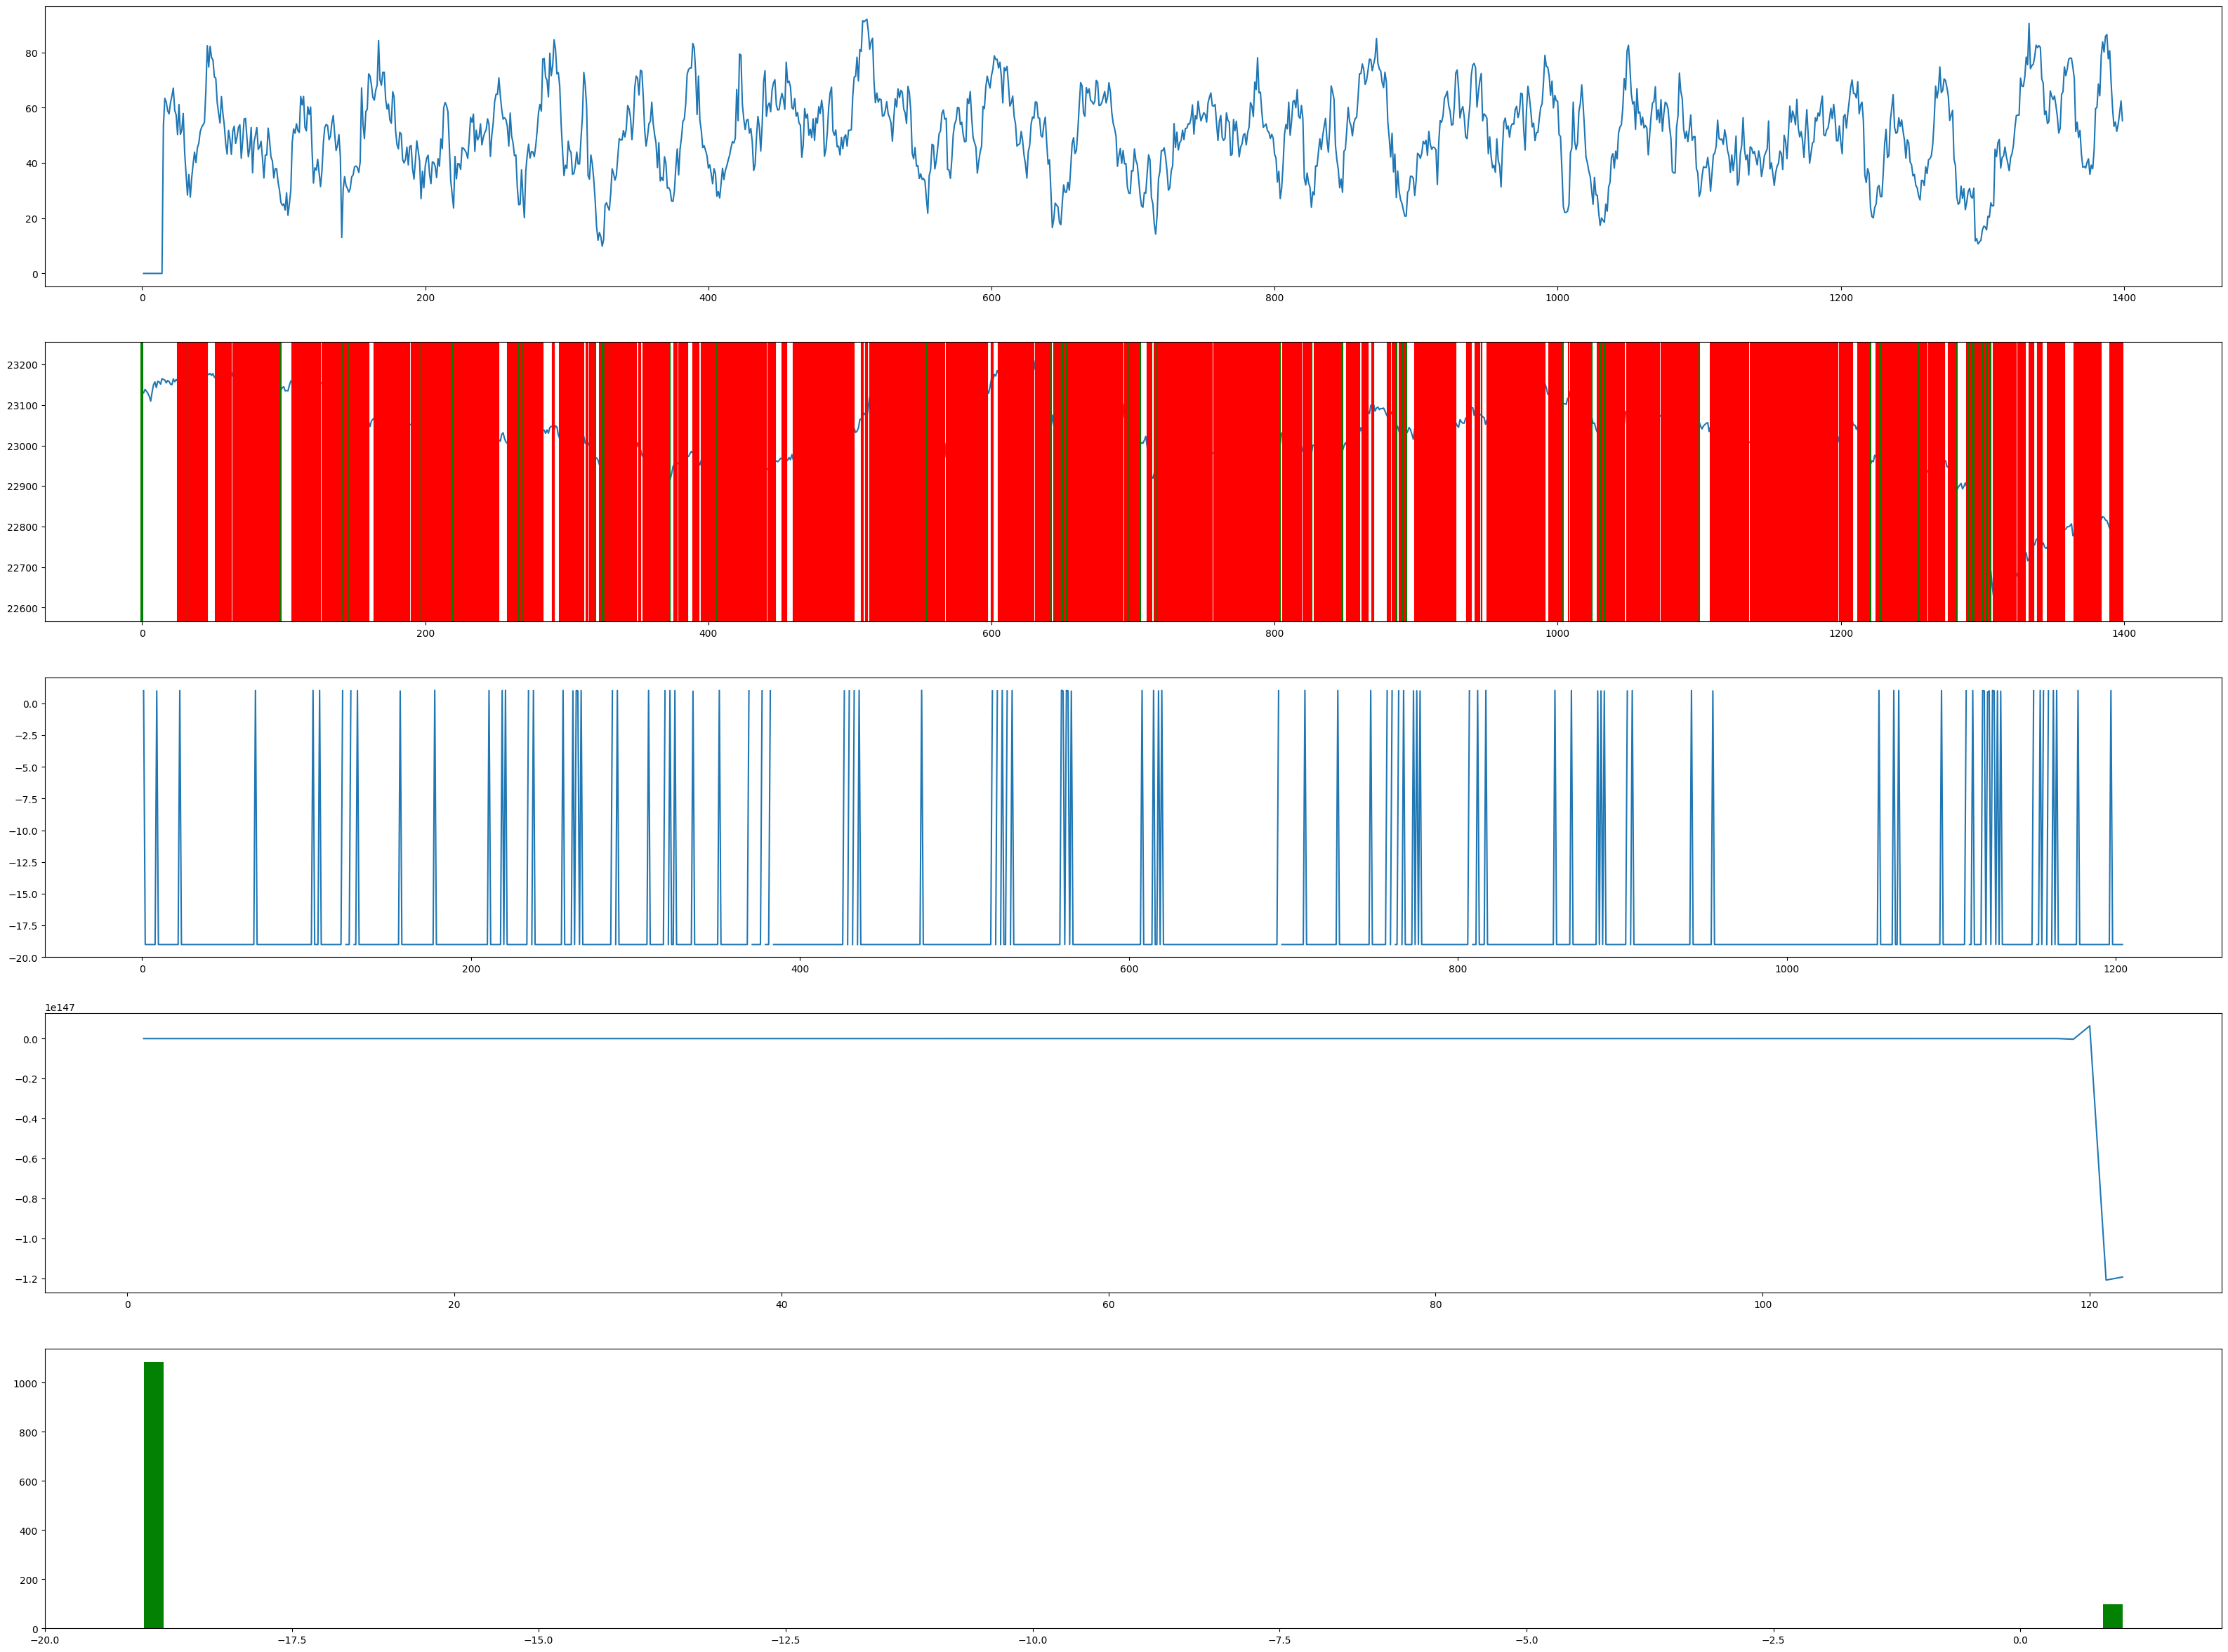

,long/short,entry,exit,index_1,index_2,time,indicatorStart,indicatorEnd,pnl,cumulativePnl,SL
0,0.0,0.0,23163.0000,0.0,25.0,25.0,0.000000,50.253807,-19.000000,-1.900000e+01,0.0
1,0.0,0.0,23159.0000,0.0,26.0,26.0,0.000000,61.111111,-19.000000,3.610000e+02,0.0
2,0.0,0.0,23160.0000,0.0,27.0,27.0,0.000000,50.318471,-19.000000,-6.859000e+03,0.0
3,0.0,0.0,23163.5000,0.0,28.0,28.0,0.000000,51.923077,-19.000000,1.303210e+05,0.0
4,0.0,0.0,23156.5000,0.0,29.0,29.0,0.000000,57.894737,-19.000000,-2.476099e+06,0.0
5,0.0,0.0,23139.0000,0.0,30.0,30.0,0.000000,43.884892,-19.000000,4.704588e+07,0.0
6,0.0,0.0,23115.0000,0.0,31.0,31.0,0.000000,35.882353,-19.000000,-8.938717e+08,0.0
7,1.0,23123.5,23107.0000,32.0,33.0,1.0,28.372093,35.779817,0.985729,-8.811151e+08,0.0
8,0.0,0.0,23118.5000,0.0,34.0,34.0,0.000000,27.615063,-19.000000,1.674119e+10,0.0
9,0.0,0.0,23125.0000,0.0,35.0,35.0,0.000000,34.630350,-19.000000,-3.180826e+11,0.0


In [297]:
# data_15m_10
# data_15m_2
# data_5m_2
# data_5m_10
#rsi_len, leverage, signal_low, signal_high, tp_long, tp_short, price_dataframe
pnl_calculator.run(14,20,30,70,50,30,data_1m_7, 10)


In [70]:
print(price)

None


In [271]:
 data_1m_7= data_assembler.get_minutes(7,"BTCUSDT", 200, 1)

processed 1 of 7
processed 2 of 7
processed 3 of 7
processed 4 of 7
processed 5 of 7
processed 6 of 7
processed 7 of 7


100000 100000 lengths
min pnl: -0.03223339944087389
average pnl: 1.0017784039099016; average pnl without leverage: 1.000088920195495
average time spent: 17.734310134310135
liquidations / stop losses: 249 
last pnlTotal: [-4.40618716  1.        ]


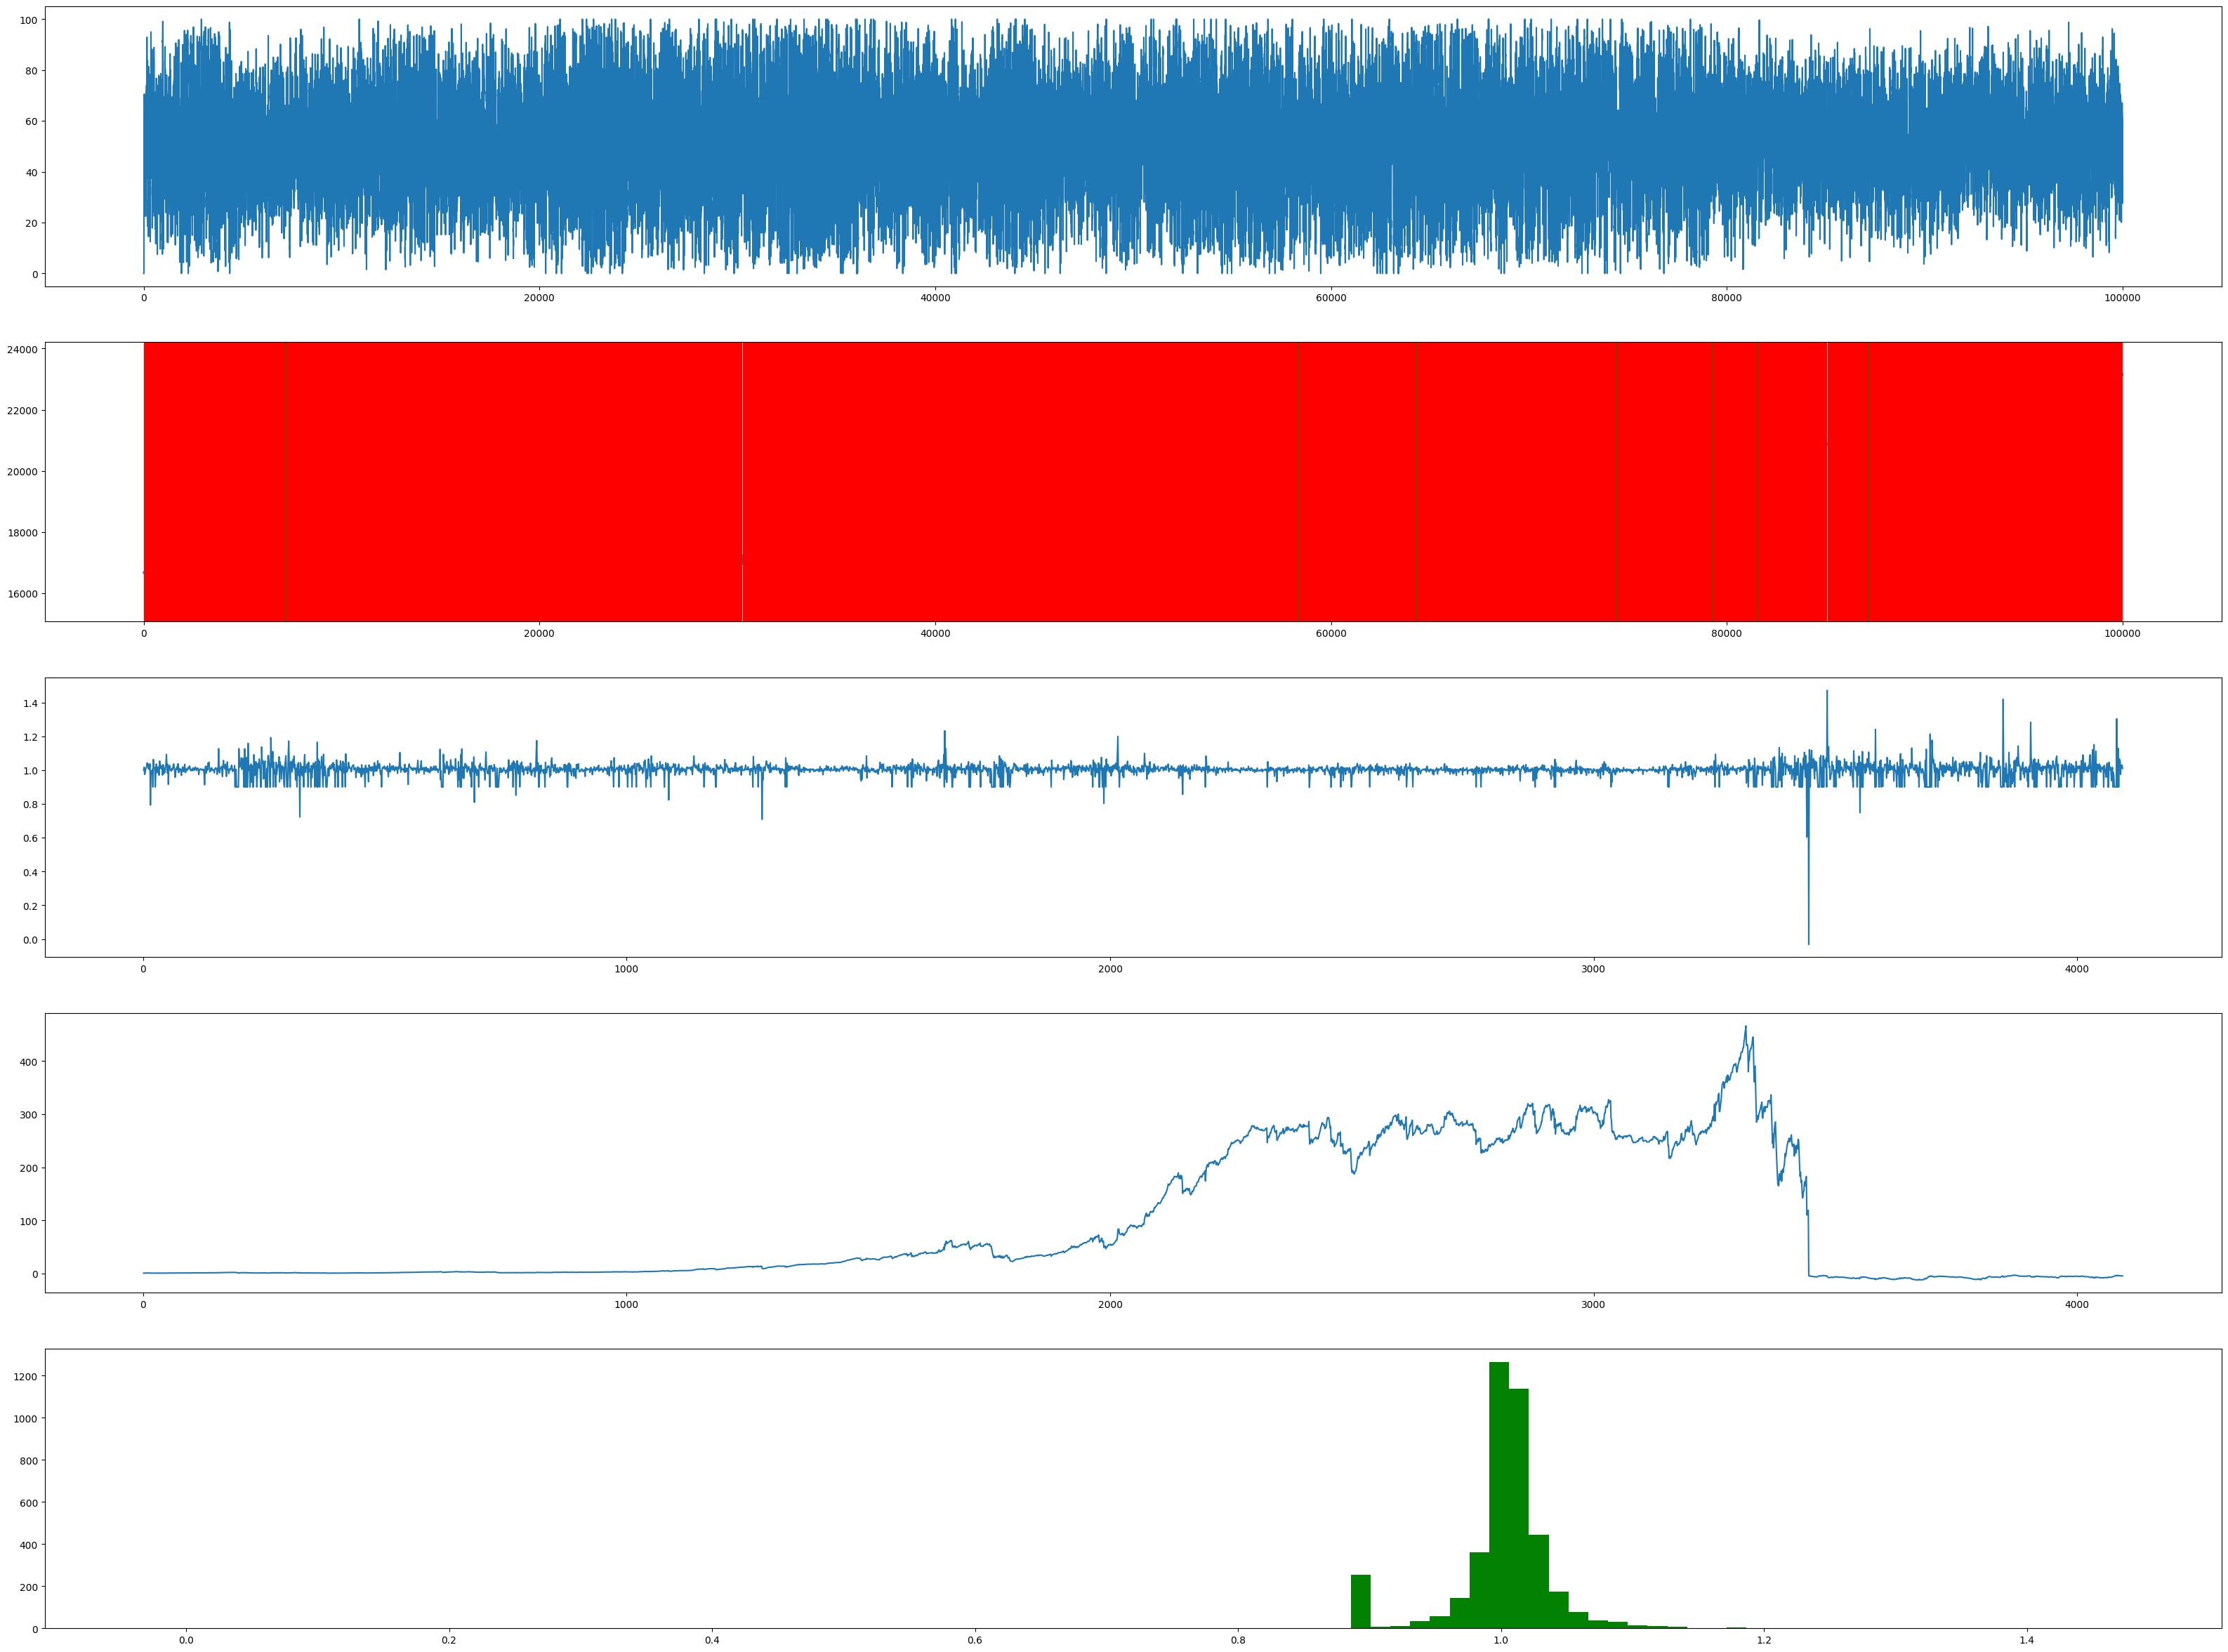

,long/short,entry,exit,index_1,index_2,time,indicatorStart,indicatorEnd,pnl,cumulativePnl,SL
0,0.0,16690.0,16675.5,33.0,50.0,17.0,70.547945,46.428571,1.017391,1.017391,0.0
1,1.0,16660.0,16638.5,58.0,88.0,30.0,25.301205,67.500000,0.974190,0.991132,0.0
2,1.0,16634.5,16621.5,99.0,123.0,24.0,22.448980,55.276382,0.984370,0.975640,0.0
3,0.0,16633.5,16629.0,133.0,150.0,17.0,71.681416,46.153846,1.005412,0.980920,0.0
4,0.0,16677.5,16666.0,164.0,209.0,45.0,91.011236,25.342466,1.013801,0.994458,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4090,1.0,23171.0,23204.0,99827.0,99843.0,16.0,25.838926,57.386364,1.028484,-4.235186,0.0
4091,0.0,23249.5,23214.5,99849.0,99863.0,14.0,72.965879,41.777778,1.030154,-4.362892,0.0
4092,1.0,23177.5,23189.0,99869.0,99886.0,17.0,29.213483,60.000000,1.009923,-4.406187,0.0
4093,0.0,23196.5,23205.0,99895.0,99916.0,0.0,70.270270,38.071066,0.000000,0.000000,0.0


In [285]:
# data_15m_10
# data_15m_2
# data_5m_2
# data_5m_10
#rsi_len, leverage, signal_low, signal_high, tp_long, tp_short, price_dataframe
# pnl_calculator.run(14,20,30,55,70,30,data_15m_10)
# pnl_calculator.run(14,20,30,55,70,30,data_15m_2)
# pnl_calculator.run(14,20,30,55,70,30,data_5m_10)
# pnl_calculator.run(14,20,30,55,70,30,data_5m_2)
pnl_calculator.run(14,20,30,70,50,50,data_1m_500, 10)
